In [1]:
O16=15.994914619257319
O18=17.999159612136690
O18-O16

2.0042449928793715

In [ ]:
Comparing just the O16 fragments
Before I can do a PCA, I need to align the values
Maybe the easiest way is to contrast all results agains all, by comparing mz and RT
Add another column in the original excel file to link with the id in the shared features DF
I think I need to contrast all features in the same sample before I contrast them with the others
Before calculating the new pooled values, let's go for the full aligment and the PCA !

In [8]:
import pandas as pd
import numpy as np
import sys
import os
home=os.getcwd()
sys.path.append(home+'/Functions')
from ShowDF import *

In [16]:
def QualityFilter(SummaryCluster,ConfidenceInterval_ppm=10, RT_std=1):
    #Add the ones that passed
    ConfidendeLocator=SummaryCluster['ConfidenceIntervalDa_1']<ConfidenceInterval_ppm
    RTLocator=SummaryCluster['StdRT_1']<RT_std
    QualityLocator= RTLocator & ConfidendeLocator
    SummaryCluster_QC=SummaryCluster[QualityLocator]
    return SummaryCluster_QC

In [17]:
home=os.getcwd()
ResultsFolder='MiasResults'
ResultsLocation=home+'/'+ResultsFolder
Samples=os.listdir(ResultsLocation)

In [134]:
import numpy as np
def FindSharedFeatures(SharedFeaturesDF,SummaryCluster,Sample,Samples,SafetyFactor_mz=3,SafetyFactor_RT=1):
    SummaryCluster['SharedFeatures']=0
    for index in SharedFeaturesDF.index:
        feature=SharedFeaturesDF.loc[index]
        RT=feature['AverageRT_1']
        RT_std=feature['StdRT_1']
        mz=feature['AverageMZ_1']
        mz_std=feature['StdMZ_1']
        SameFeatureLocator_RTmax=(SummaryCluster['AverageRT_1']+SafetyFactor_RT*SummaryCluster['StdRT_1'])>(RT-SafetyFactor_RT*RT_std)
        SameFeatureLocator_RTmin=(SummaryCluster['AverageRT_1']-SafetyFactor_RT*SummaryCluster['StdRT_1'])<(RT+SafetyFactor_RT*RT_std)
        SameFeatureLocator_RT=SameFeatureLocator_RTmax & SameFeatureLocator_RTmin    
        SameFeatureLocator_mzmax=(SummaryCluster['AverageMZ_1']+SafetyFactor_mz*SummaryCluster['StdMZ_1'])>mz-SafetyFactor_mz*mz_std
        SameFeatureLocator_mzmin=(SummaryCluster['AverageMZ_1']-SafetyFactor_mz*SummaryCluster['StdMZ_1'])<mz+SafetyFactor_mz*mz_std
        SameFeatureLocator_mz=SameFeatureLocator_mzmax & SameFeatureLocator_mzmin    
        SameFeatureLocator=SameFeatureLocator_mz & SameFeatureLocator_RT
        SummaryCluster.loc[SameFeatureLocator,'SharedFeatures']=1        
        if (len(SummaryCluster[SameFeatureLocator]))>0:
            SharedFeaturesDF[Sample][index]=SummaryCluster['SumInt_1'][SameFeatureLocator].mean()
    NewFeaturesLocator=SummaryCluster['SharedFeatures']==0
    NewFeatures=SummaryCluster.loc[NewFeaturesLocator,['AverageRT_1','StdRT_1','AverageMZ_1','StdMZ_1']]
    NnewFeatures=len(NewFeatures)
    NSamples=len(Samples)
    NewFeaturesSamplesMat=np.zeros([NnewFeatures,NSamples])
    NewFeatures[Samples]=NewFeaturesSamplesMat
    NewFeatures[Sample]=SummaryCluster.loc[NewFeaturesLocator,['SumInt_1']]
    SharedFeaturesDF=SharedFeaturesDF.append(NewFeatures,ignore_index=True)
    return SharedFeaturesDF

In [137]:
FirstSample=pd.read_excel(ResultsLocation+'/'+Samples[0],index_col=0)
SafetyFactor_mz=3
SafetyFactor_RT=1
#I also need to update the values 
SharedFeaturesDF=QualityFilter(FirstSample)[['AverageRT_1','StdRT_1','AverageMZ_1','StdMZ_1']]
NFeatures=len(SharedFeaturesDF)
NSamples=len(Samples)
FeaturesSamplesMat=np.zeros([NFeatures,NSamples])
SharedFeaturesDF[Samples]=FeaturesSamplesMat
print(len(SharedFeaturesDF))
for Sample in Samples:
    SummaryCluster=pd.read_excel(ResultsLocation+'/'+Sample,index_col=0)
    SummaryCluster=QualityFilter(SummaryCluster)
    SharedFeaturesDF=FindSharedFeatures(SharedFeaturesDF,SummaryCluster,Sample,Samples,SafetyFactor_mz=3,SafetyFactor_RT=1)
    print(len(SharedFeaturesDF))
SharedFeaturesDF=SharedFeaturesDF.sort_values(by='AverageMZ_1')

130
130
162
198
216
233
446
452
456


In [136]:
ShowDF(SharedFeaturesDF)

,AverageRT_1,StdRT_1,AverageMZ_1,StdMZ_1,SFC_S1C_11.mzML.xlsx,SFC_S1C_1.mzML.xlsx,SFC_S1_6.mzML.xlsx,SFC_S1C_6.mzML.xlsx,SFC_S1C_5.mzML.xlsx,SFC_S1_11.mzML.xlsx,SFC_S1_1.mzML.xlsx,SFC_S1_5.mzML.xlsx
233,7.23557,0.033334,97.0765,0.000378761,0,0,0,0,0,741210,0,0
130,6.73592,0.0174848,116.082,0.000156463,0,268812,0,1.76161e+06,1.9111e+06,0,0,0
162,6.43724,0.0252394,128.954,7.12311e-05,0,0,1.0257e+07,1.08293e+07,1.7627e+07,1.2487e+07,0,0
234,7.2431,0.0275931,131.084,0.00215838,0,0,0,0,0,111168,0,0
198,5.82045,0.0605107,137.046,0.000382484,0,0,0,224480,0,0,0,0
199,6.20006,0.0155224,137.047,0.000276194,0,0,0,1.65936e+06,0,0,0,0
0,6.42027,0.0150889,160.979,0.000712973,232410,0,0,0,286829,0,0,0
1,7.91746,0.0518795,172.108,0.000589025,277391,0,0,0,0,0,0,0
2,4.32675,0.011704,180.102,0.00013542,3.14072e+06,3.58579e+06,3.22887e+06,3.40885e+06,3.58529e+06,3.49821e+06,3.72686e+06,3.3072e+06
3,4.33028,0.008859,181.105,0.000486898,174048,0,138509,235050,161220,212257,260571,308997


In [144]:
SharedFeaturesDF.to_excel('AlignedFeatures.xlsx')

In [95]:
len(Samples)

8

In [138]:
NFeatures=len(SharedFeaturesDF)
NSamples=len(Samples)
FeaturesSamplesMat=np.zeros([NFeatures,NSamples])
sampleCount=0
for sample in Samples:
    FeaturesData=SharedFeaturesDF[sample]/sum(SharedFeaturesDF[sample])
    FeaturesSamplesMat[:,sampleCount]=FeaturesData
    sampleCount+=1

In [139]:
import numpy as np
from sklearn.decomposition import PCA
X=FeaturesSamplesMat.T
pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[4.82729928e-01 2.84611295e-01 1.05491471e-01 5.35517799e-02
 3.59063717e-02 2.28695679e-02 1.48395862e-02 2.27961945e-32]
[1.20800317e-01 9.27560034e-02 5.64708905e-02 4.02348991e-02
 3.29459264e-02 2.62932906e-02 2.11800440e-02 2.62510778e-17]


In [140]:
M=pca.transform(X)

In [97]:
import matplotlib.pyplot as plt

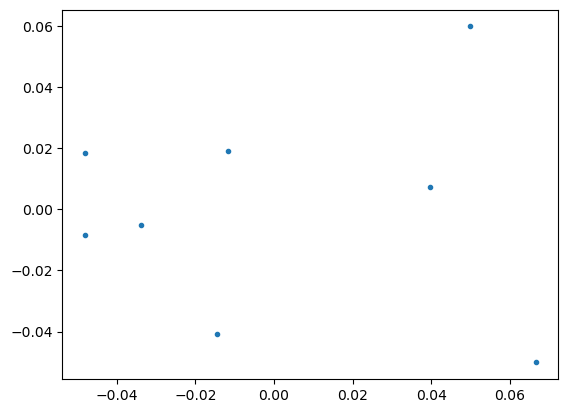

In [141]:
plt.plot(M[:,0],M[:,1],'.')

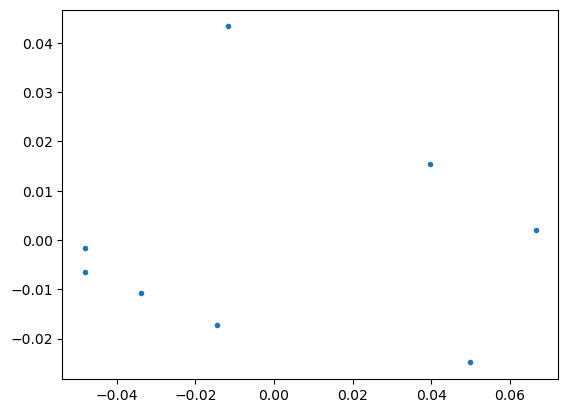

In [142]:
plt.plot(M[:,0],M[:,2],'.')

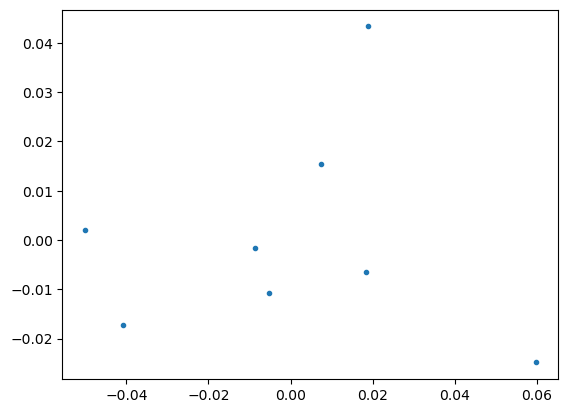

In [143]:
plt.plot(M[:,1],M[:,2],'.')

In [87]:
help(pca)

Help on PCA in module sklearn.decomposition._pca object:

class PCA(sklearn.decomposition._base._BasePCA)
 |  PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA).
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |

In [83]:
pca

PCA(n_components=2)

In [81]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)